In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
# Modelling
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [2]:
df = pd.read_csv('data/stud.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Prepping X and y variable

In [3]:
X = df.drop('math_score', axis=1)
y = df['math_score']

In [4]:
# Create Column Transformer with 3 types of Transformers
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

standard_scaler = StandardScaler()
onehot_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", onehot_encoder, cat_features),
        ("Standardization", standard_scaler, num_features)
    ]
)

prep_X = preprocessor.fit_transform(X)
prep_X.shape

(1000, 19)

In [5]:
# Separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(prep_X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate function to get all metrics after model training

In [6]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    # 'K-Neighbors Regressor': KNeighborsRegressor(),
    'DecisionTree Regressor': DecisionTreeRegressor(max_depth=5),
    'RandomForest Regressor': RandomForestRegressor(),
    'XGB Regressor': XGBRegressor(max_depth=5),
    'CatBoosting Regressor': CatBoostRegressor(verbose=False),
    'AdaBoosting Regressor': AdaBoostRegressor()
}
model_list = []
r2_list = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_mae, train_rmse, train_r2_square = evaluate_model(train_preds, y_train)
    test_mae, test_rmse, test_r2_square = evaluate_model(test_preds, y_test)
    model_list.append((model_name, train_r2_square, test_r2_square))

    print(model_name)
    print("Model Performance for Training Set")
    print("- Mean Absolute Error:", train_mae)
    print("- Root Mean Squared Error:", train_rmse)
    print("- R2 Score:", train_r2_square)
    print("-"*35)
    print("Model Performance for Test Set")
    print("- Mean Absolute Error:", test_mae)
    print("- Root Mean Squared Error:", test_rmse)
    print("- R2 Score:", test_r2_square)
    print("="*35)
    print("\n"*2)

Linear Regression
Model Performance for Training Set
- Mean Absolute Error: 4.266711846071957
- Root Mean Squared Error: 5.323050852720513
- R2 Score: 0.8562503455164387
-----------------------------------
Model Performance for Test Set
- Mean Absolute Error: 4.214763142474853
- Root Mean Squared Error: 5.393993869732845
- R2 Score: 0.8670435914705477



Lasso
Model Performance for Training Set
- Mean Absolute Error: 5.206302661246526
- Root Mean Squared Error: 6.593815587795566
- R2 Score: 0.6903948906164419
-----------------------------------
Model Performance for Test Set
- Mean Absolute Error: 5.157881810347763
- Root Mean Squared Error: 6.51969453566742
- R2 Score: 0.727536565502517



Ridge
Model Performance for Training Set
- Mean Absolute Error: 4.264987823725982
- Root Mean Squared Error: 5.323324922741654
- R2 Score: 0.8557734008261899
-----------------------------------
Model Performance for Test Set
- Mean Absolute Error: 4.211100688014261
- Root Mean Squared Error: 5.39038

In [8]:
pd.DataFrame(model_list, columns=['model_name', 'train_r2_square', 'test_r2_square']).sort_values(by='test_r2_square', ascending=False)

,model_name,train_r2_square,test_r2_square
0,Linear Regression,0.856250,0.867044
2,Ridge,0.855773,0.866795
4,RandomForest Regressor,0.974180,0.822157
6,CatBoosting Regressor,0.955005,0.811383
5,XGB Regressor,0.983474,0.800610
7,AdaBoosting Regressor,0.806813,0.797965
3,DecisionTree Regressor,0.830425,0.772791
1,Lasso,0.690395,0.727537


### So we choose Linear Regression

In [9]:
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_pred, y_test)*100
print(f"Accuracy of the Model is {round(score, 3)} %")

Accuracy of the Model is 86.704 %


#### PLOT y_pred and y_test

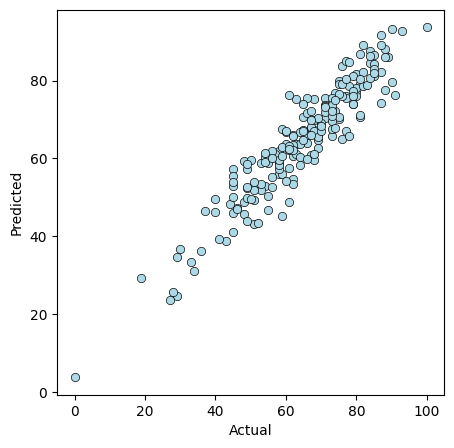

In [10]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred, color='lightblue', edgecolor='black')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

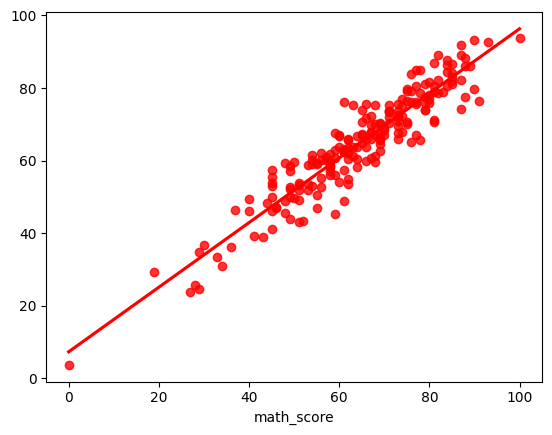

In [11]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red',);

#### Difference between Actual and Predicted Values


In [12]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
